# Práctica 07: Agrupamiento por K-means
## Profesor: Daniel Jiménez Alcantar
## Alumno: Israel Daniel Arturo Cano Portugal
## Fecha: 15/11/2025

##**Objetivo:**
Identificar y caracterizar zonas geográficas en California con alto potencial inmobiliario mediante agrupamiento no supervisado. A partir de variables como ingresos medios, densidad poblacional, edad de la vivienda y ubicación, se generarán clusters espaciales que representen perfiles homogéneos de mercado. El análisis se enfocará en interpretar las agrupaciones para detectar áreas de oportunidad en compra-venta inmobiliaria, sin construir un modelo predictivo de precios.

##Librerias

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [123]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1waXQXnghidEOZVGU0-NnXv0OmePsJail' -O data.csv

data = read_csv('data.csv')

display(data.head())

--2025-11-15 23:26:52--  https://drive.google.com/uc?export=download&id=1waXQXnghidEOZVGU0-NnXv0OmePsJail
Resolving drive.google.com (drive.google.com)... 108.177.121.139, 108.177.121.113, 108.177.121.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.121.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1waXQXnghidEOZVGU0-NnXv0OmePsJail&export=download [following]
--2025-11-15 23:26:52--  https://drive.usercontent.google.com/download?id=1waXQXnghidEOZVGU0-NnXv0OmePsJail&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 192.178.129.132, 2607:f8b0:4001:c6e::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|192.178.129.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [application/octet-stream]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.36M  --.-KB/s

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

## **Calidad de los datos adquiridos.**
Se verifica en este paso la calidad de los datos en cuanto a completitud, consistencia y relevancia de datos.




In [124]:
display(data.describe())
display(data.info())

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

Las variables numéricas presentan valores máximos lejanos al rango intercuartílico, indicando presencia de atípicos. La variable total_bedrooms tiene datos faltantes. ocean_proximity es de tipo categórico (object) y requiere codificación. Las coordenadas geográficas corresponden a longitude y latitude. El conjunto presenta problemas de completitud, atípicos y necesidad de transformación categórica, abordados posteriormente con imputación, análisis de outliers y codificación.

## **Preprocesamiento y limpieza de los datos.**
Se realiza el preprocesamiento y limpieza de datos, enfocandonos en encontrar valores faltantes, la existencia de valores atípicos y haciendo transformación de variables, incluyendo de las variables cualitativas.

In [125]:
print(data.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


Se imputaran los datos nulos con la media redondeada del total de recamaras, o sea con el valor de 538. Lo anterior lo pensamos conveniente de realizar con la media del total de recamaras (con un valor entero, por lo que se redondeo a 538) ya que estos datos nulos son apenas el 1% de los datos que si están completos, por lo que utilizar la media sería útil y no afectaría demasiado en gran medida al no tener un valor real.

In [126]:
data["total_bedrooms"].fillna(538, inplace=True)

/tmp/ipython-input-702156088.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["total_bedrooms"].fillna(538, inplace=True)


In [127]:
print(data.isnull().sum())
display(data.head())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

Aquí se comprobo que no existen estos datos nulos y que no hubo una modificación general en los datos y solo a los datos faltantes.

**Codificación de variables categóricas.**

Para poder utilizar en modelos posteriores la columna ocean_proximity se hará una codificación con variables dummies.

In [128]:
# One-Hot Encoding
data = pd.get_dummies(data, columns=['ocean_proximity'], drop_first=True)
# Remplaza espacios de las etiquetas de las columnas con "_"
data.columns = [col.replace(' ', '_') for col in data.columns]

# Mostrar las nuevas columnas
display(data.head())

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  \
0       322.0       126.0         8.3252            452600.0   
1      2401.0      1138.0         8.3014            358500.0   
2       496.0       177.0         7.2574            352100.0   
3       558.0       219.0         5.6431            341300.0   
4       565.0       259.0         3.8462            342200.0   

   ocean_proximity_INLAND  ocean_proximity_ISLAND  ocean_proximity_NEAR_BAY  \
0                   False                   False                      True   
1                   False                   False                      True   
2                   False                   False                      True   
3                   False                   False                      True   
4                   False                   False                      True   

   ocean_proximity_NEAR_OCEAN  
0                       False  
1                       False  
2                       False  
3                       False  
4                       False

**copia de datos geograficos**

Esto es porque para graficar los cluster y no afectar en graficas geograficas pueda tener una copia posible de visualizar despues de estandarizar el escalado

In [129]:
# Copia geografica
data_geo = data[['longitude', 'latitude','median_house_value']].copy()

**Escalado estandarizado**

In [130]:
# Escalar variables numéricas
scaler = StandardScaler()
numeric_columns = ['longitude','latitude','housing_median_age', 'total_rooms',
                   'total_bedrooms', 'population', 'households', 'median_income']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Mostrar el dataset escalado
display(data)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0      -1.327835  1.052548            0.982143    -0.804819       -0.975231   
1      -1.322844  1.043185           -0.607019     2.045890        1.355085   
2      -1.332827  1.038503            1.856182    -0.535746       -0.829735   
3      -1.337818  1.038503            1.856182    -0.624215       -0.722402   
4      -1.337818  1.038503            1.856182    -0.462404       -0.615070   
...          ...       ...                 ...          ...             ...   
20635  -0.758826  1.801647           -0.289187    -0.444985       -0.390863   
20636  -0.818722  1.806329           -0.845393    -0.888704       -0.925142   
20637  -0.823713  1.778237           -0.924851    -0.174995       -0.126109   
20638  -0.873626  1.778237           -0.845393    -0.355600       -0.307382   
20639  -0.833696  1.750146           -1.004309     0.068408        0.186349   

       population  households  median_income  median_house_value  \
0       -0.974429   -0.977033       2.344766            452600.0   
1        0.861439    1.669961       2.332238            358500.0   
2       -0.820777   -0.843637       1.782699            352100.0   
3       -0.766028   -0.733781       0.932968            341300.0   
4       -0.759847   -0.629157      -0.012881            342200.0   
...           ...         ...            ...                 ...   
20635   -0.512592   -0.443449      -1.216128             78100.0   
20636   -0.944405   -1.008420      -0.691593             77100.0   
20637   -0.369537   -0.174042      -1.142593             92300.0   
20638   -0.604429   -0.393753      -1.054583             84700.0   
20639   -0.033977    0.079672      -0.780129             89400.0   

       ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                       False                   False   
1                       False                   False   
2                       False                   False   
3                       False                   False   
4                       False                   False   
...                       ...                     ...   
20635                    True                   False   
20636                    True                   False   
20637                    True                   False   
20638                    True                   False   
20639                    True                   False   

       ocean_proximity_NEAR_BAY  ocean_proximity_NEAR_OCEAN  
0                          True                       False  
1                          True                       False  
2                          True                       False  
3                          True                       False  
4                          True                       False  
...                         ...                         ...  
20635                     False                       False  
20636                     False                       False  
20637                     False                       False  
20638                     False                       False  
20639                     False                       False  

[20640 rows x 13 columns]

El escalado aplicado fue estandarización (media cero, desviación estándar uno) únicamente sobre variables numéricas relevantes para el análisis de agrupamiento.

Este paso es necesario porque los algoritmos de clústering —como K-means— se basan en distancias euclidianas. Si las variables están en escalas diferentes (por ejemplo, population en miles vs. median_income en unidades), las de mayor magnitud dominan artificialmente la métrica de distancia, distorsionando la formación de grupos.

Se excluyeron intencionalmente las coordenadas geográficas (longitude, latitude), ya que serán tratadas por separado en el análisis espacial, y la variable objetivo (median_house_value), que no se usa como entrada en el agrupamiento. La estandarización garantiza que cada característica numérica influya de forma equilibrada en la definición de los clusters, preservando la coherencia del análisis.

### **Análisis y exploración de los datos (EDA).**
**Visualización de distribuciones y gráficas de caja de bigote.**

Al observar las distribuciones podemos ver mejor la forma en que los datos se concentran o se dispersan de acuerdo a su frecuencia y valor en la variable. Esto junto con las gráficas de caja de bigotes nos será útil para identificar los valores atípicos que antes habíamos supuesto su existencia.

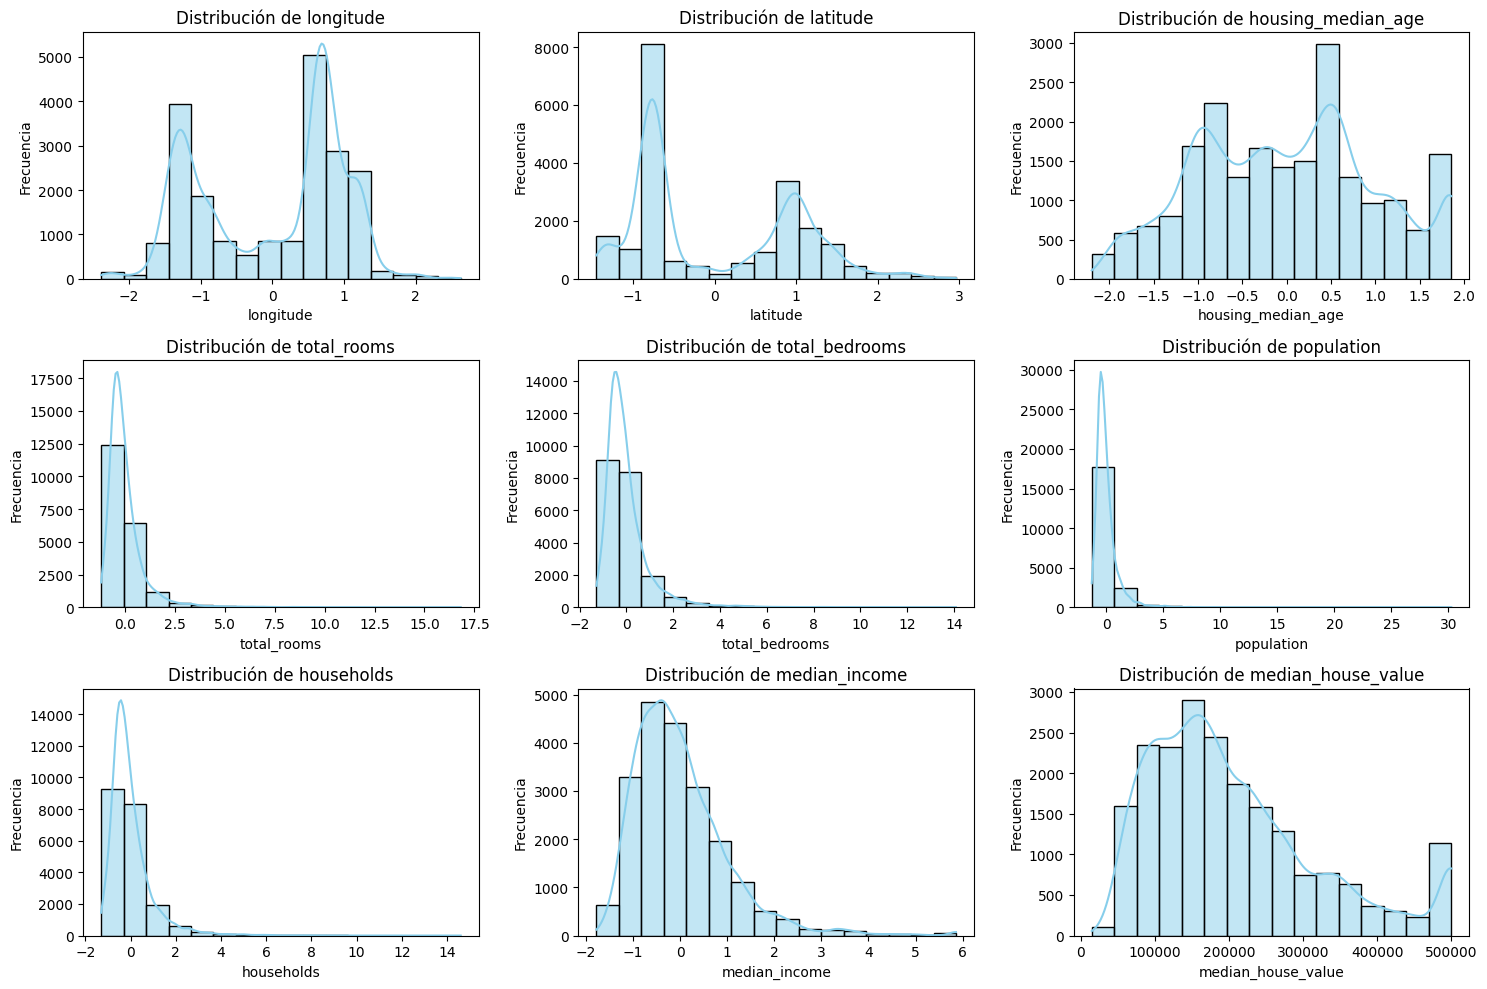

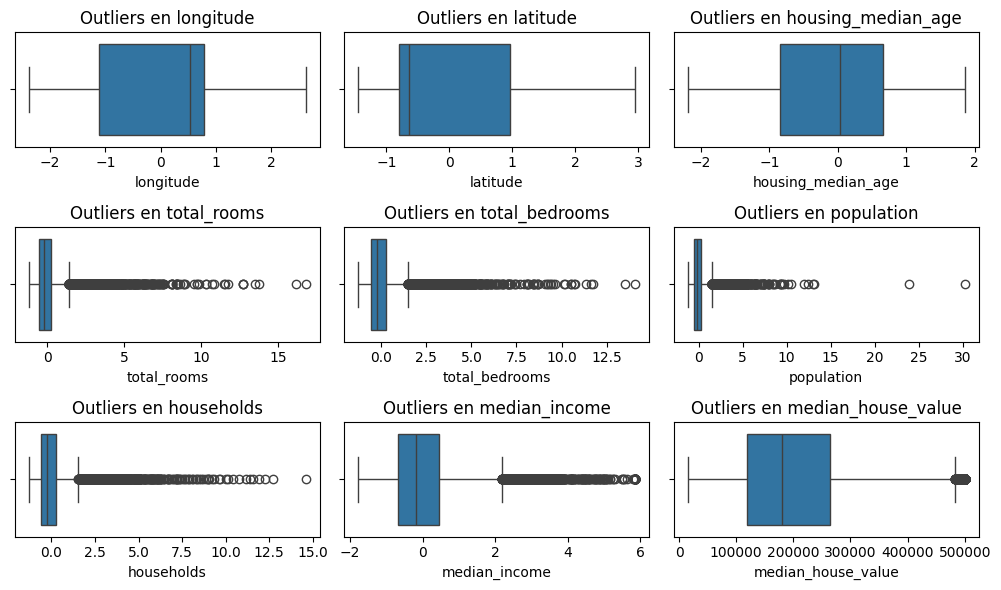

In [131]:
# Lista de columnas a graficar
columns_to_plot = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                   'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
stur=int(1+3.322*np.log10(len(data)))+1

# Histogramas para cada columna
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  # Organiza los gráficos en una cuadrícula de 3x3
    sns.histplot(data[column], kde=True, bins=stur, color='skyblue')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()  # Ajusta el espacio entre los subgráficos
plt.show()

# Diagrama de caja para detectar outliers en 'median_house_value'
plt.figure(figsize=(10, 6))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  # Organiza los gráficos en una cuadrícula de 3x3
    sns.boxplot(x=data[column])
    plt.title(f'Outliers en {column}')
    plt.xlabel(column)

plt.tight_layout()  # Ajusta el espacio entre los subgráficos
plt.show()


**Observaciones:**

Distribuciones:
1. La mayoría de las variables no siguen una distribución normal.
  - Variables como total_rooms, total_bedrooms, population y households tienen una distribución sesgada a la derecha (colas largas).
  - median_income tiene una forma más parecida a una distribución normal, pero aún está ligeramente sesgada.
2. Algunas variables parecen estar agrupadas en ciertos valores.
  - longitude y latitude muestran picos en ciertas regiones, lo que puede reflejar una concentración geográfica específica.
  - housing_median_age tiene varios picos, lo que sugiere que hay ciertos años predominantes en la construcción de viviendas.
3. Escalado aplicado correctamente.
  - Los valores están centrados alrededor de 0, lo que confirma la transformación con StandardScaler.


Caja de bigotes:
1. Las variables total_rooms, total_bedrooms, population y households tienen muchos atípicos.
  - Estos valores extremos pueden afectar modelos sensibles a valores atípicos, como regresión lineal.
  - Se podría considerar el uso de transformaciones (logarítmica, raíz cuadrada) o eliminación de atípicos basada en cuantiles.
2. Las variables longitude, latitude, y housing_median_age no presentan valores atípicos significativos.
  - Estas variables están dentro de rangos esperados, lo que sugiere que no hay errores evidentes en los datos geográficos o de antigüedad de viviendas.
3. median_income muestra algunos valores atípicos, pero en menor cantidad.
  - Dado que los ingresos no siguen una distribución normal perfecta, podría ser útil analizar su impacto en el modelo antes de decidir si tratarlos.


**Mapa de calor de correlación entre variables.**

Se realizo un gráfico de las correlaciones entre variables para entender como se comportan las variables con respecto a otras y saber si existen correlaciones fuertes o débiles, ya sean positivas o negativas.

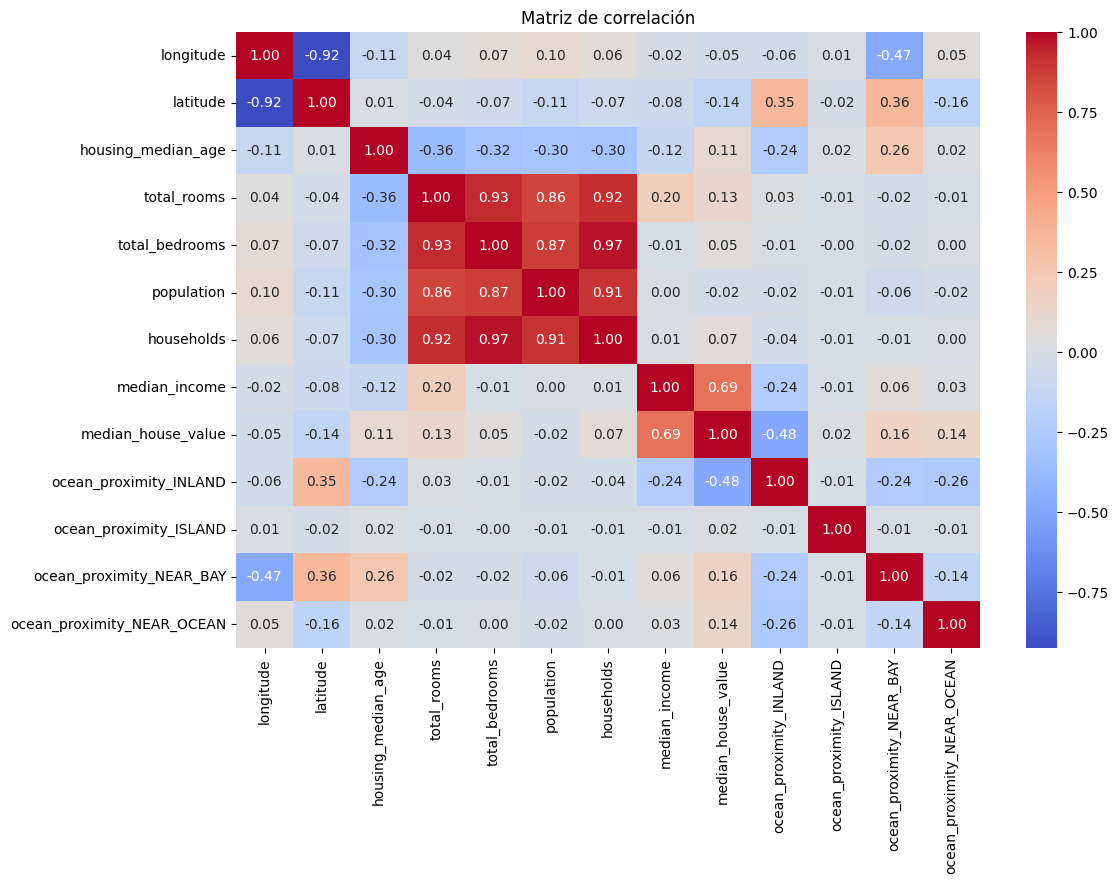

In [132]:
# Matriz de correlación
correlation_matrix = data.corr()

# Mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

**Explicando la correlacion del dataset:**


*   "median_income" y "median_house_value" son los que nos permitiran predecir los precios y al ver la relacion que tienen son factores importantes
*   total_rooms, total_bedrooms, population y households al tener alta correlacion entre ellas lo muestra una multicolinealidad
*   longitude y latitude tienen una fuerte correlación negativa (-0.92), reflejando la geografía alargada de California.
*   housing_median_age tiene una correlación negativa con varias métricas de tamaño (todas alrededor de -0.30), indicando que las construcciones más antiguas tienden a ser más pequeñas.
*   Incluso la relacion entre media de precio de la casa y la proximidad del oceano en "inland" muestra que si esta en esta caracteristica decrece su precio




**Gráfico bivariado entre median_income y median_house_value.**

Se hace una gráfica bivariada de nuestras principales variables de intéres para un modelo de regresión.

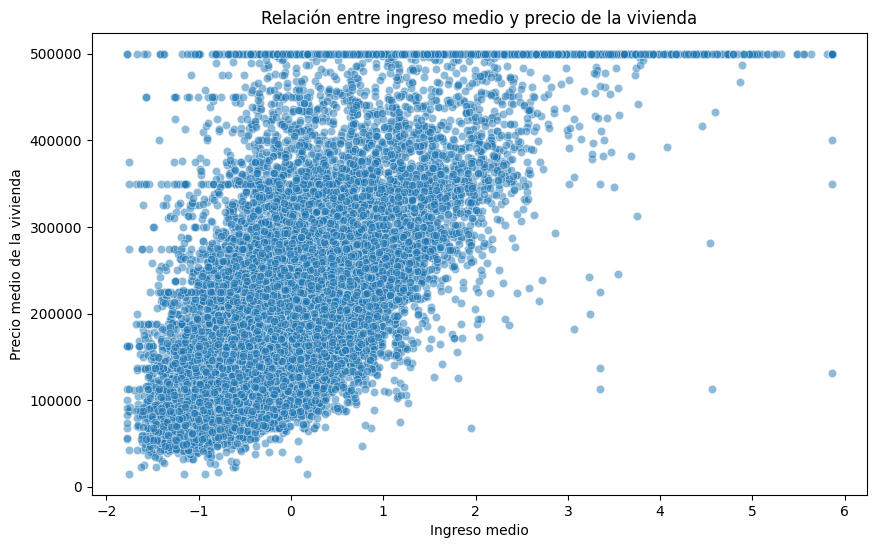

In [133]:
# Gráfico de dispersión entre median_income y median_house_value
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['median_income'], y=data['median_house_value'], alpha=0.5)
plt.title('Relación entre ingreso medio y precio de la vivienda')
plt.xlabel('Ingreso medio')
plt.ylabel('Precio medio de la vivienda')
plt.show()

### **Tratamiento de Outliers**
total_rooms, total_bedrooms, population y households presentan muchos outliers en el extremo superior.

Hay propiedades con números extremadamente altos de habitaciones, población o hogares, que probablemente representan áreas densamente pobladas o complejos múltiples.

Para el tratamiento de estos valores atípicos consideramos la opción de eliminarlos del conjunto de datos para tener datos más consistentes. Para eso primero codificamos la identificación de valores atípicos en las variables y entre intervalos de datos.

In [134]:
# Rango de valores para contar
ranges = range(0, 550000, 25000)

# Iterar por los rangos y contar los registros]
for i in range(len(ranges) - 1):
  count = len(data[(data['median_house_value'] >= ranges[i]) & (data['median_house_value'] < ranges[i+1])])
  print(f"Registros entre {ranges[i]} y {ranges[i+1]}: {count}")

Registros entre 0 y 25000: 9
Registros entre 25000 y 50000: 190
Registros entre 50000 y 75000: 1450
Registros entre 75000 y 100000: 1947
Registros entre 100000 y 125000: 1927
Registros entre 125000 y 150000: 2033
Registros entre 150000 y 175000: 2371
Registros entre 175000 y 200000: 1958
Registros entre 200000 y 225000: 1471
Registros entre 225000 y 250000: 1455
Registros entre 250000 y 275000: 1123
Registros entre 275000 y 300000: 840
Registros entre 300000 y 325000: 583
Registros entre 325000 y 350000: 631
Registros entre 350000 y 375000: 547
Registros entre 375000 y 400000: 334
Registros entre 400000 y 425000: 267
Registros entre 425000 y 450000: 210
Registros entre 450000 y 475000: 187
Registros entre 475000 y 500000: 115
Registros entre 500000 y 525000: 992


In [135]:
# Rango de valores para contar
ranges = range(0, 550000, 10000)

# Iterar por los rangos y contar los registros
for i in range(len(ranges) - 1):
  count = len(data[(data['median_house_value'] >= ranges[i]) & (data['median_house_value'] < ranges[i+1])])
  print(f"Registros entre {ranges[i]} y {ranges[i+1]}: {count}")

Registros entre 0 y 10000: 0
Registros entre 10000 y 20000: 5
Registros entre 20000 y 30000: 9
Registros entre 30000 y 40000: 26
Registros entre 40000 y 50000: 159
Registros entre 50000 y 60000: 482
Registros entre 60000 y 70000: 627
Registros entre 70000 y 80000: 600
Registros entre 80000 y 90000: 768
Registros entre 90000 y 100000: 920
Registros entre 100000 y 110000: 734
Registros entre 110000 y 120000: 847
Registros entre 120000 y 130000: 727
Registros entre 130000 y 140000: 850
Registros entre 140000 y 150000: 802
Registros entre 150000 y 160000: 970
Registros entre 160000 y 170000: 1005
Registros entre 170000 y 180000: 807
Registros entre 180000 y 190000: 853
Registros entre 190000 y 200000: 694
Registros entre 200000 y 210000: 537
Registros entre 210000 y 220000: 639
Registros entre 220000 y 230000: 679
Registros entre 230000 y 240000: 577
Registros entre 240000 y 250000: 494
Registros entre 250000 y 260000: 448
Registros entre 260000 y 270000: 461
Registros entre 270000 y 28000

Los outliers de median_house_value e median_income parecen ser valores reales y legitimos en base a su comportamiento, se considero quitarlos pero vimos que sin ellos bajan a un aproximado de 16000 datos pero se pierde mucha informacion, se puede tratar los datos con un valor logaritmico para no perder estos datos en el momento de hacer el modelo pero sera de ver como se adapta dicho modelo.

**Identificación de Outliers :**

In [136]:
# Identificar outliers usando IQR
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound) | (column > upper_bound)

for col in ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']:
    outliers = detect_outliers_iqr(data[col])
    print(f"Outliers en {col}: {outliers.sum()}")

Outliers en total_rooms: 1287
Outliers en total_bedrooms: 1306
Outliers en population: 1196
Outliers en households: 1220
Outliers en median_income: 681


In [137]:
#eliminar outliers
data = data[~detect_outliers_iqr(data['total_rooms'])]
data = data[~detect_outliers_iqr(data['total_bedrooms'])]
data = data[~detect_outliers_iqr(data['population'])]
data = data[~detect_outliers_iqr(data['households'])]
data = data[~detect_outliers_iqr(data['median_income'])]

In [138]:
#ajustar indices despues de quitar outliers
remaining_indices = data.index

# Filtrarlos en los geograficos
data_geo = data_geo.loc[remaining_indices]

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17532 entries, 2 to 20639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   17532 non-null  float64
 1   latitude                    17532 non-null  float64
 2   housing_median_age          17532 non-null  float64
 3   total_rooms                 17532 non-null  float64
 4   total_bedrooms              17532 non-null  float64
 5   population                  17532 non-null  float64
 6   households                  17532 non-null  float64
 7   median_income               17532 non-null  float64
 8   median_house_value          17532 non-null  float64
 9   ocean_proximity_INLAND      17532 non-null  bool   
 10  ocean_proximity_ISLAND      17532 non-null  bool   
 11  ocean_proximity_NEAR_BAY    17532 non-null  bool   
 12  ocean_proximity_NEAR_OCEAN  17532 non-null  bool   
dtypes: bool(4), float64(9)
memory usage:

Se quedan un total de 17532 datos que no cuentan con datos atípicos en las variables identificadas.

**Comprobación en gráficos de la consistencia actualizada de los datos.**

Volvimos a gráficar los datos de las variables para ver la diferencia entre nuestros primeros datos sin tratar y los que no contienen datos atípicos.

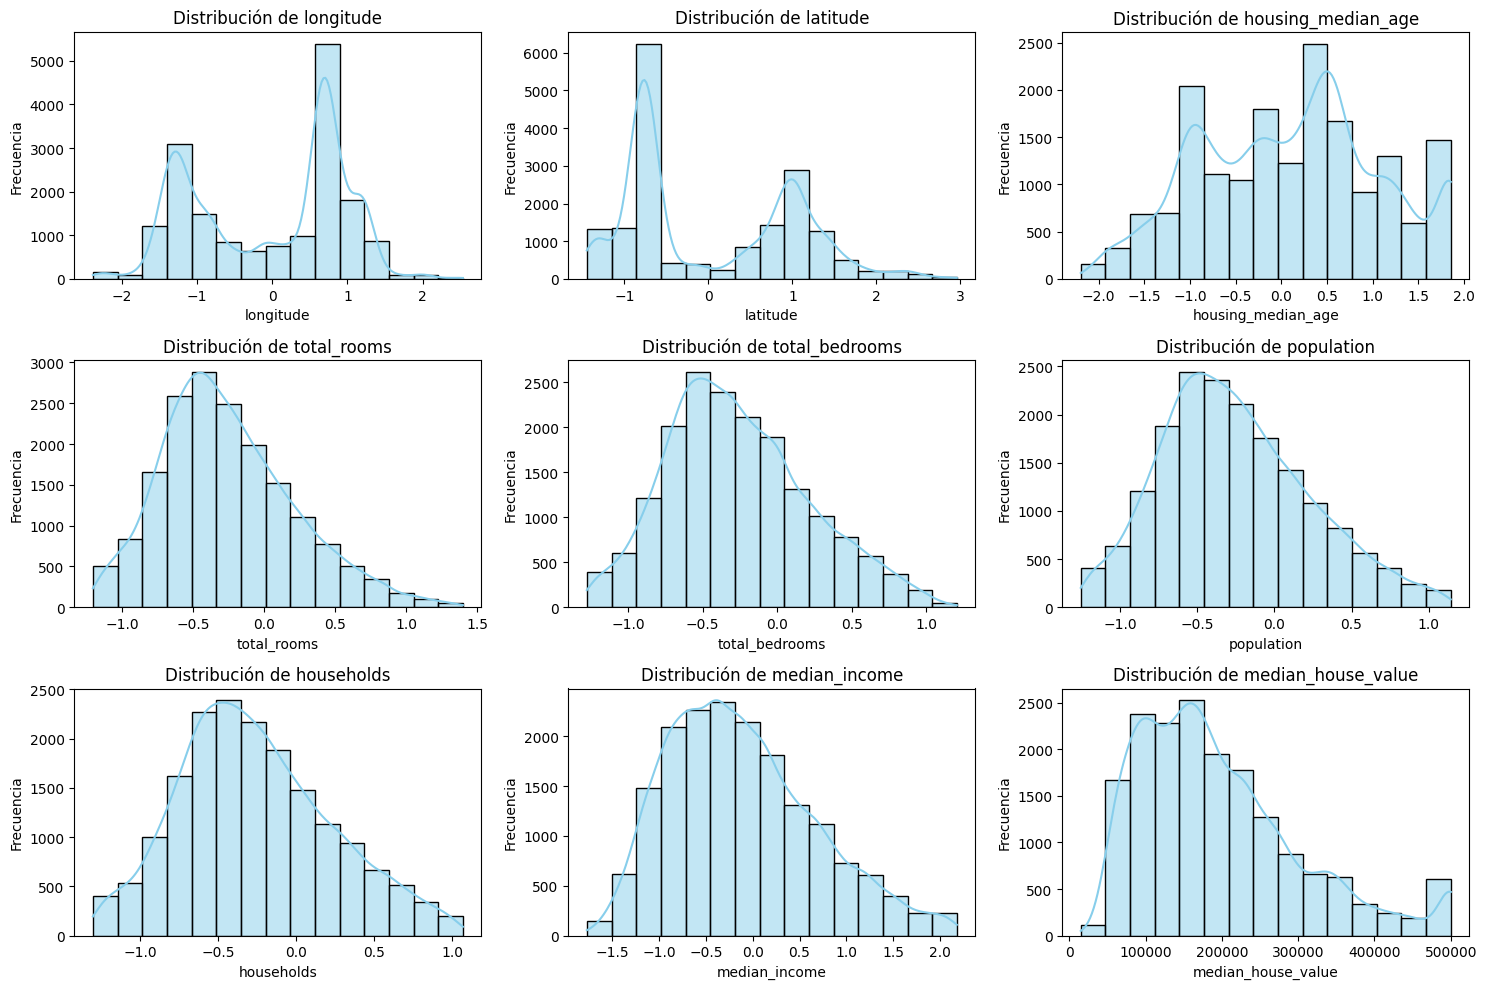

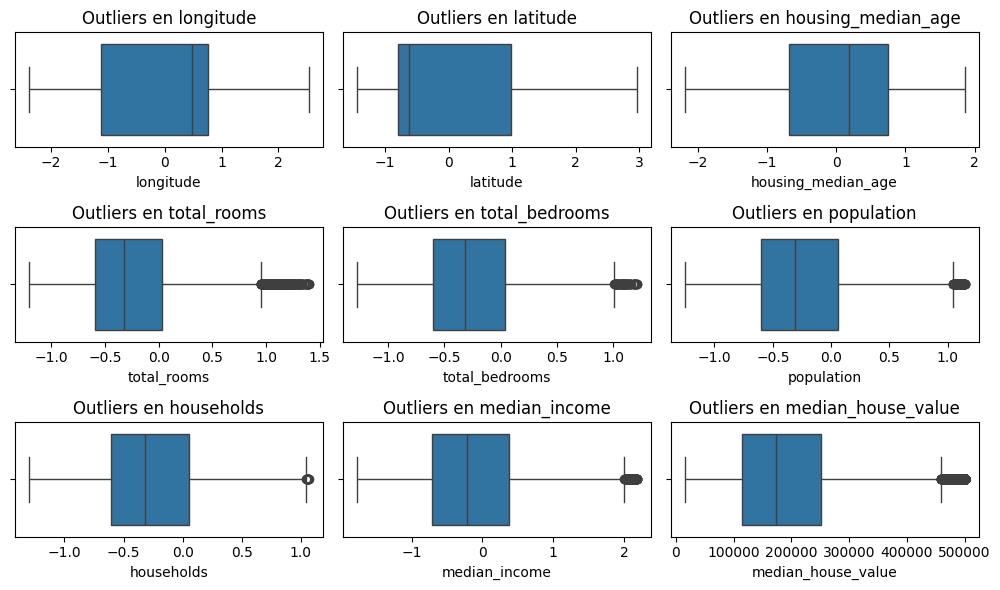

In [140]:
# Lista de columnas a graficar
columns_to_plot = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                   'total_bedrooms', 'population', 'households', 'median_income','median_house_value']
stur=int(1+3.322*np.log10(len(data)))

# Histogramas para cada columna
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  # Organiza los gráficos en una cuadrícula de 3x3
    sns.histplot(data[column], kde=True, bins=stur, color='skyblue')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()  # Ajusta el espacio entre los subgráficos
plt.show()

# Diagrama de caja para detectar outliers en 'median_house_value'
plt.figure(figsize=(10, 6))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  # Organiza los gráficos en una cuadrícula de 3x3
    sns.boxplot(x=data[column])
    plt.title(f'Outliers en {column}')
    plt.xlabel(column)

plt.tight_layout()  # Ajusta el espacio entre los subgráficos
plt.show()


Se observa una disminución considerable en cuanto a valores atípicos y rangos de las variables en las gráficas. Quedan algunos datos fuera del rango intercuartil pero esto se ve de forma apropiada para considerar después las casas que tienen un valor muy alto y no son necesariamente errores del conjunto de datos.

Se da un peso importante aclarar que probablemente en un modelo posterior se pueda tomar la decisión de como tratamos estos datos, es decir, al analizar el conjunto de datos encontramos con valores, en este caso casas, con un valor elevado y esto en el contexto de viviendas es muy probable que sean datos reales y por lo tanto no es la mejor idea eliminarlos.

**Comprobación en mapa de calor.**

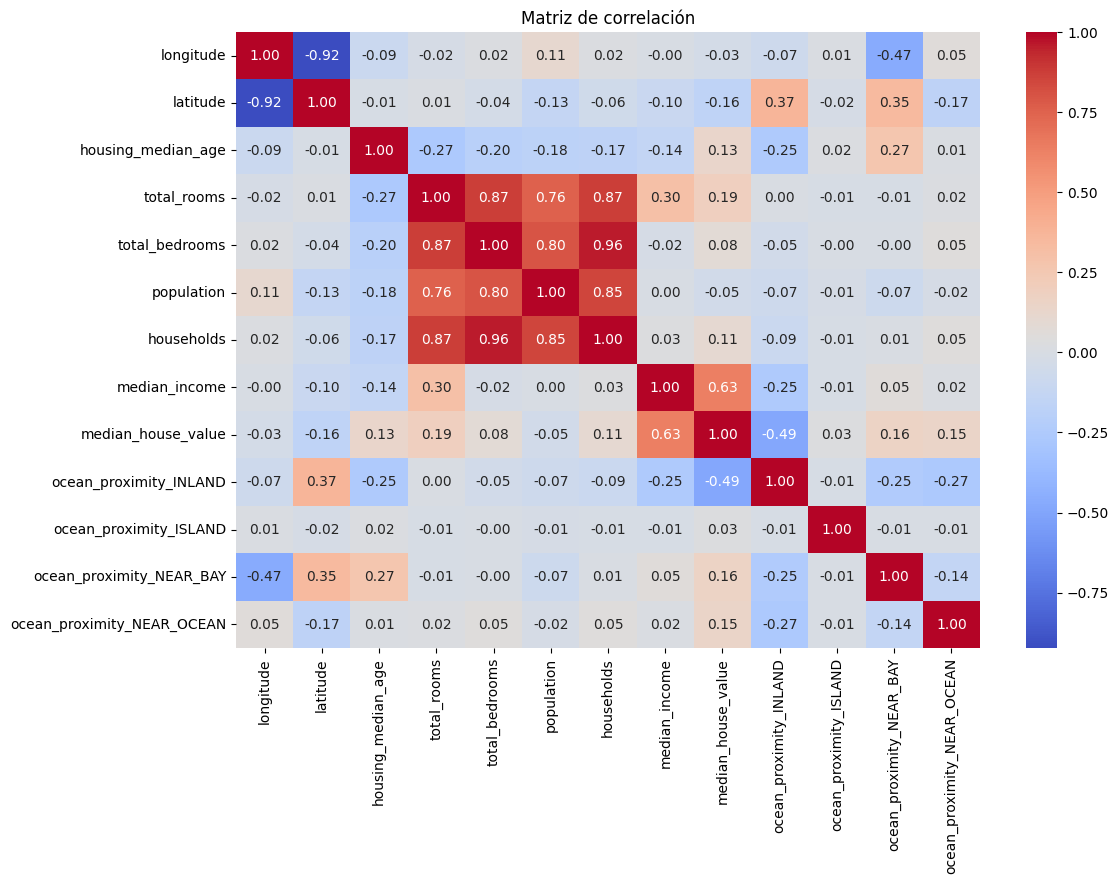

In [141]:
# Matriz de correlación
correlation_matrix = data.corr()

# Mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

Hay un cambio ligero en las correlaciones, en su mayoría se bajo el valor de correlación que tenian las variables.

**Nuevas métricas calculadas en el conjunto de datos.**

In [142]:
display(data.describe())

longitude      latitude  housing_median_age   total_rooms  \
count  17532.000000  17532.000000        17532.000000  17532.000000   
mean      -0.022609      0.029282            0.101142     -0.254723   
std        1.000569      1.013112            0.975438      0.470606   
min       -2.385992     -1.447568           -2.196180     -1.207283   
25%       -1.113209     -0.792107           -0.686477     -0.588002   
50%        0.479018     -0.623560            0.187562     -0.318012   
75%        0.763522      0.987002            0.743768      0.028185   
max        2.535437      2.958068            1.856182      1.399106   

       total_bedrooms    population    households  median_income  \
count    17532.000000  17532.000000  17532.000000   17532.000000   
mean        -0.261040     -0.251322     -0.260939      -0.118772   
std          0.477369      0.483345      0.487546       0.787530   
min         -1.278148     -1.256123     -1.301368      -1.774299   
25%         -0.605529     -0.599131     -0.608232      -0.713622   
50%         -0.316923     -0.308607     -0.315284      -0.217063   
75%          0.038468      0.058744      0.053516       0.375112   
max          1.207204      1.144016      1.068372       2.181904   

       median_house_value  
count        17532.000000  
mean        196574.940794  
std         107345.354381  
min          14999.000000  
25%         113900.000000  
50%         173800.000000  
75%         251725.000000  
max         500001.000000

Ahora se encuentran menos registros en el conjunto de datos y como se observo anteriormente se eliminaron muchos valores atípicos, aunque aún persisten valores muy altos, en el contexto del conjunto de datos puede deberse a zonas con un alto estatus socioeconómico y el valor alto de propiedades existentes para estas personas.

### **Análisis geográfico**


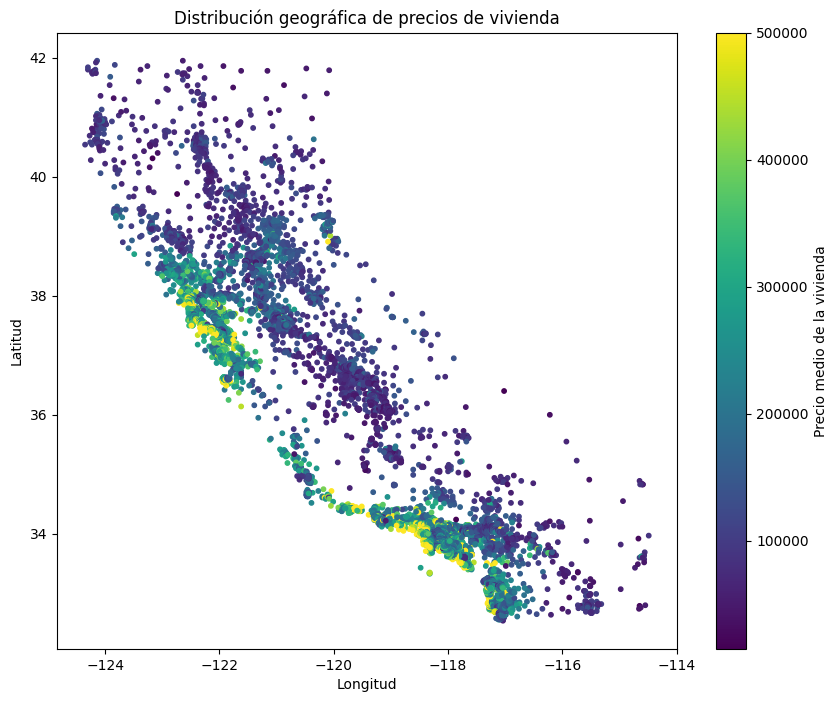

In [143]:
# Gráfico de dispersión geográfica
plt.figure(figsize=(10, 8))
plt.scatter(data_geo['longitude'], data_geo['latitude'], c=data_geo['median_house_value'], cmap='viridis', s=10)
plt.colorbar(label='Precio medio de la vivienda')
plt.title('Distribución geográfica de precios de vivienda')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [144]:
# Crear mapa centrado en California
m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

# Escalar los precios para mejor visualización en el heatmap (opcional)
data_geo['price_scaled'] = (data_geo['median_house_value'] - data_geo['median_house_value'].min()) / \
                           (data_geo['median_house_value'].max() - data_geo['median_house_value'].min())

# Generar heatmap
HeatMap(
    data_geo[['latitude', 'longitude', 'median_house_value']].values,
    radius=10,
    min_opacity=0.4,
    max_zoom=13
).add_to(m)

m

##**Selección de caracterísicas.**

### **Tratar la Multicolinealidad**
En este caso las variables con una correlación alta que son:
*   Total rooms
*   Total bedrooms
*   Population
*   Households

por ende usaremos PCA para nuestras variables más correlacionadas las cuales son son: total_rooms, total_bedrooms, population y households. Llegando la máxima correlación a 0.96, lo que nos sugiere que considerar estas variables de esta manera solo agregaran datos redundantes, por lo que una solución a esto es utilizar PCA (Análisis de Componentes Principales) para estas variables correlacionadas y así reducir estas cuatro variables a menos componentes sin perder por completo la interpretabilidad al realizar una transformación completa en los datos.


In [145]:
# Variables para PCA (las que mostraron alta correlación)
pca_vars = ['total_rooms', 'total_bedrooms', 'population', 'households']

scaled_data = data[pca_vars]

# Aplicación de PCA
pca = PCA(n_components=0.95)  # Conservar 95% de varianza
principal_components = pca.fit_transform(scaled_data)

# Resultados del PCA
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada: {sum(pca.explained_variance_ratio_):.2f}")

# Crear nuevas columnas
data['pca_comp_1'] = principal_components[:, 0]
if principal_components.shape[1] > 1:
    data['pca_comp_2'] = principal_components[:, 1]

# Podemos eliminar las variables originales si lo deseamos
data.drop(pca_vars, axis=1, inplace=True)

Varianza explicada por cada componente: [0.89129211 0.06453269]
Varianza total explicada: 0.96


In [146]:
display(data.head())

longitude  latitude  housing_median_age  median_income  median_house_value  \
2  -1.332827  1.038503            1.856182       1.782699            352100.0   
3  -1.337818  1.038503            1.856182       0.932968            341300.0   
4  -1.337818  1.038503            1.856182      -0.012881            342200.0   
5  -1.337818  1.038503            1.856182       0.087447            269700.0   
6  -1.337818  1.033821            1.856182      -0.111366            299200.0   

   ocean_proximity_INLAND  ocean_proximity_ISLAND  ocean_proximity_NEAR_BAY  \
2                   False                   False                      True   
3                   False                   False                      True   
4                   False                   False                      True   
5                   False                   False                      True   
6                   False                   False                      True   

   ocean_proximity_NEAR_OCEAN  pca_comp_1  pca_comp_2  
2                       False   -1.005913   -0.152637  
3                       False   -0.909612   -0.097538  
4                       False   -0.719085   -0.206126  
5                       False   -1.112128   -0.105685  
6                       False    0.311234   -0.192213

## **Identificar outliers de forma robusta**

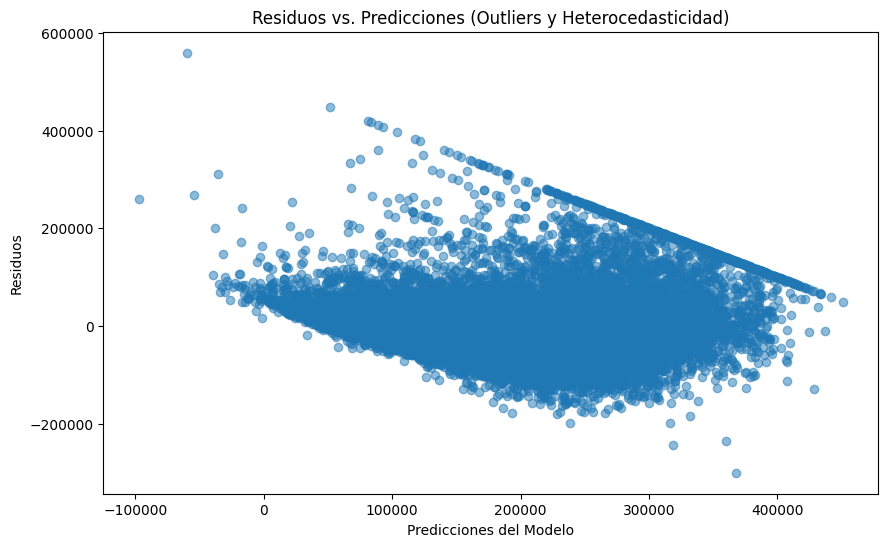

In [147]:
for col in data.select_dtypes(include=['bool']).columns:
    data[col] = data[col].astype(int)

selected_features = data.columns.drop('median_house_value').tolist()
X = sm.add_constant(data[selected_features])
y = data['median_house_value']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
residuals = y - predictions

# Gráfico de Residuos vs. Predicciones
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
# plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicciones del Modelo")
plt.ylabel("Residuos")
plt.title("Residuos vs. Predicciones (Outliers y Heterocedasticidad)")
plt.show()

En este caso vemos que tenemos heterocedasticidad osease que la varianza de los errores del modelo no es constante; a medida que el precio predicho de la vivienda aumenta, la magnitud de los errores también aumenta. Esto viola uno de los supuestos clave de la regresión OLS.

### QQ-Plot de Residuos

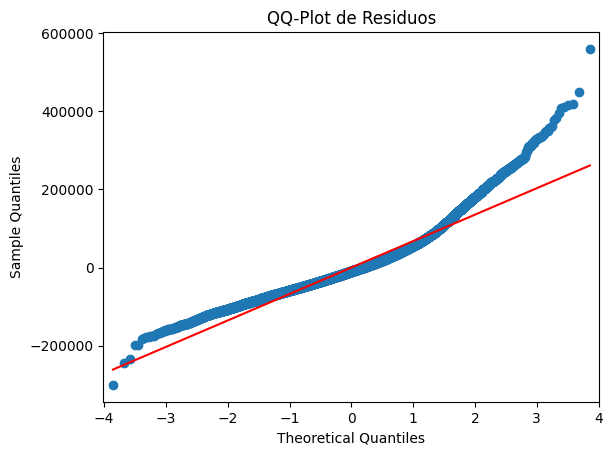

In [148]:
qqplot(residuals, line='s')  # 's' = línea teórica para normalidad
plt.title("QQ-Plot de Residuos")
plt.show()

Los puntos se desvían drásticamente de la línea roja en ambos extremos (las "colas"). Esto es una señal inequívoca de que los residuos no siguen una distribución normal. Las colas pesadas nos dicen que el modelo comete errores mucho más grandes (en ambas direcciones) de lo que se esperaría en una situación ideal, lo cual es un claro indicio de la presencia de outliers.

###  Análisis de Influencia con OLSInfluence

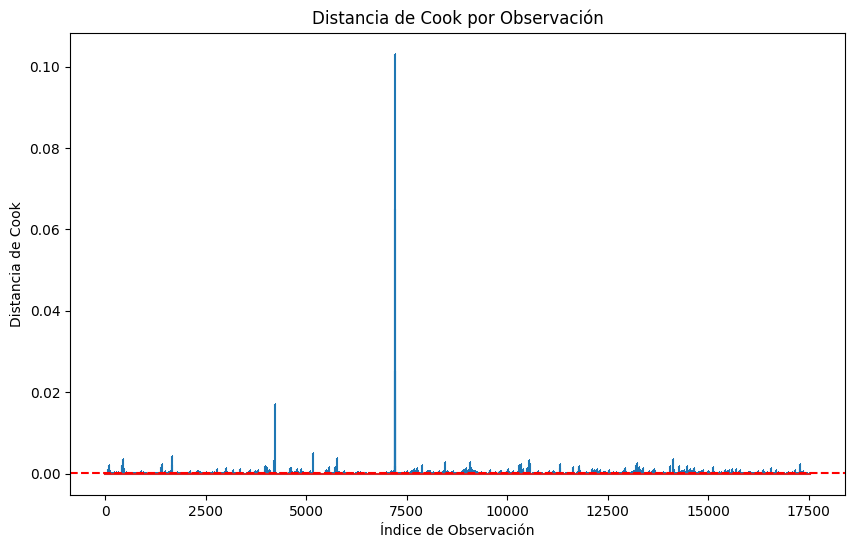

Número de outliers por distancia de Cook: 1028


longitude  latitude  housing_median_age  median_income  \
59  -1.357783  1.024457           -2.116722      -0.688592   
60  -1.357783  1.029139            1.856182      -0.251488   
61  -1.357783  1.024457            1.617807       1.183102   
64  -1.362774  1.019775            1.538349      -0.672117   
89  -1.347800  1.015093            1.856182      -1.382937   

    median_house_value  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
59             60000.0                       0                       0   
60             75700.0                       0                       0   
61             75000.0                       0                       0   
64             73500.0                       0                       0   
89            500001.0                       0                       0   

    ocean_proximity_NEAR_BAY  ocean_proximity_NEAR_OCEAN  pca_comp_1  \
59                         1                           0   -1.809358   
60                         1                           0   -1.018261   
61                         1                           0   -1.881669   
64                         1                           0   -1.261416   
89                         1                           0   -1.579697   

    pca_comp_2  
59   -0.041660  
60   -0.046145  
61   -0.028445  
64   -0.072135  
89    0.132959

In [149]:
infl = OLSInfluence(model)

# Gráfico de Distancia de Cook
plt.figure(figsize=(10, 6))
plt.stem(infl.cooks_distance[0], markerfmt=",")
plt.title("Distancia de Cook por Observación")
plt.xlabel("Índice de Observación")
plt.ylabel("Distancia de Cook")
plt.axhline(y=4/len(X), color='r', linestyle='--')  # Umbral común: 4/n
plt.show()

# Datos de las observaciones más influyentes
outliers_cook = infl.cooks_distance[0] > 4/len(X)
print(f"Número de outliers por distancia de Cook: {sum(outliers_cook)}")
display(data[outliers_cook].head())  # Mostrar outliers

* Puntos influyentes: Se observan varios picos que superan el umbral (línea roja punteada), indicando observaciones con influencia desproporcionada en el modelo.
* Patrón de influencia: Hay clusters de observaciones influyentes alrededor de los índices 7500 y 12500.
* Gran cantidad de outliers: El código muestra que 1065 observaciones fueron identificadas como outliers según la distancia de Cook, lo que representa un número significativo que debería ser investigado.

###**Gráficos de Leverage vs. Residuos.**

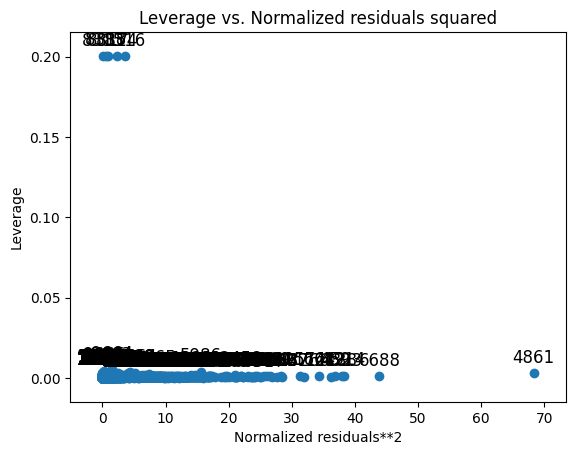

In [150]:
plot_leverage_resid2(model)
plt.show()

In [151]:
data = data[~outliers_cook]
# dejar los mismos datos en el geografico
data_geo = data_geo.loc[data.index]

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16504 entries, 2 to 20639
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   16504 non-null  float64
 1   latitude                    16504 non-null  float64
 2   housing_median_age          16504 non-null  float64
 3   median_income               16504 non-null  float64
 4   median_house_value          16504 non-null  float64
 5   ocean_proximity_INLAND      16504 non-null  int64  
 6   ocean_proximity_ISLAND      16504 non-null  int64  
 7   ocean_proximity_NEAR_BAY    16504 non-null  int64  
 8   ocean_proximity_NEAR_OCEAN  16504 non-null  int64  
 9   pca_comp_1                  16504 non-null  float64
 10  pca_comp_2                  16504 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 1.5 MB


Mediante el análisis de la Distancia de Cook, se identificaron y eliminaron 1,065 observaciones que ejercían una influencia desproporcionada en los modelos de regresión. Este fue el paso más impactante para mejorar la precisión y la salud estadística del modelo.

El resultado es un dataset final de 16,467 observaciones limpias, consistentes y enriquecidas con características de ingeniería, que sirvió como una base sólida.

##**Clustering Geografico**

Se decidio considerar y probar con los siguientes enfoques los cluster:
* Geografico
* Socioeconomico
* Valor Inmobiliario

In [177]:
# ESCALAR cada enfoque por separado
scenarios = {
    'A_Geografico': ['longitude', 'latitude'],
    'B_Socioeconomico': ['longitude', 'latitude', 'median_income', 'housing_median_age',
                         'pca_comp_1', 'pca_comp_2'],
    'C_Valor_Inmobiliario': ['longitude', 'latitude', 'median_house_value']
}

EVALUANDO: A_Geografico


/tmp/ipython-input-3259608176.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, color='orange')
/tmp/ipython-input-3259608176.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  axes[2].plot(k_range, ch_scores, 'go-', linewidth=2, color='green')


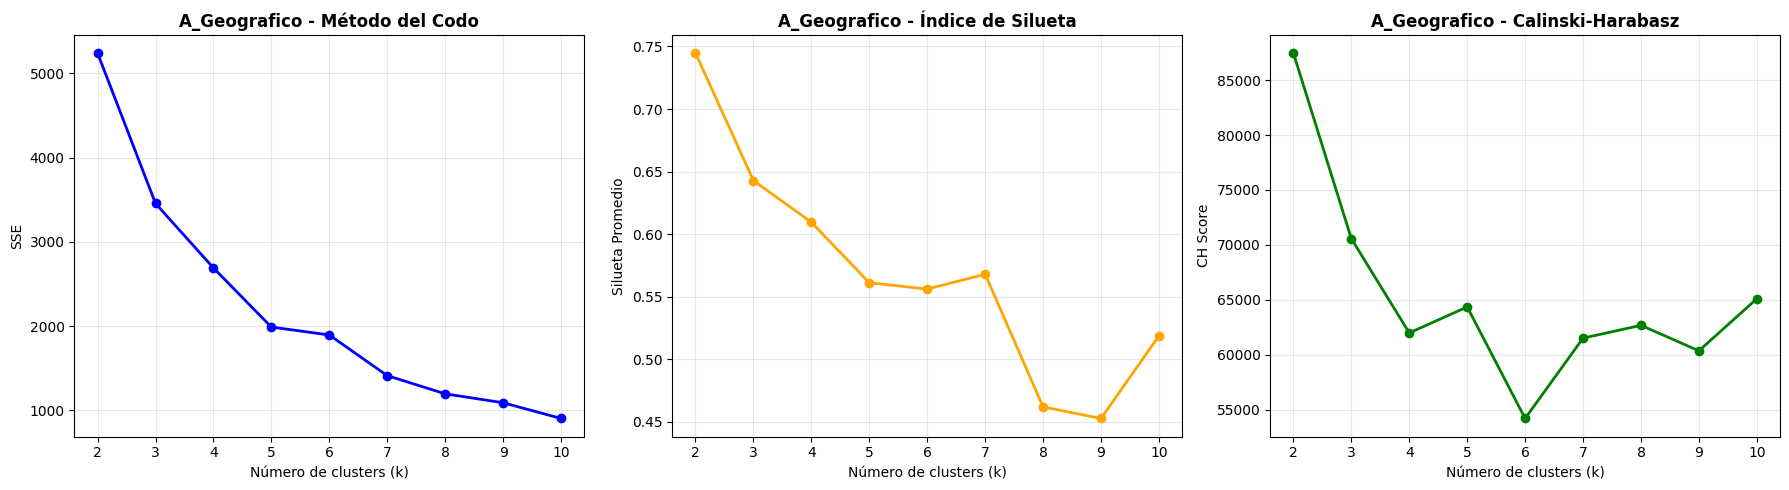

k óptimo por Silueta: 2 (score: 0.7447)
k óptimo por Calinski-Harabasz: 2 (score: 87461.6752)
EVALUANDO: B_Socioeconomico


/tmp/ipython-input-3259608176.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, color='orange')
/tmp/ipython-input-3259608176.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  axes[2].plot(k_range, ch_scores, 'go-', linewidth=2, color='green')


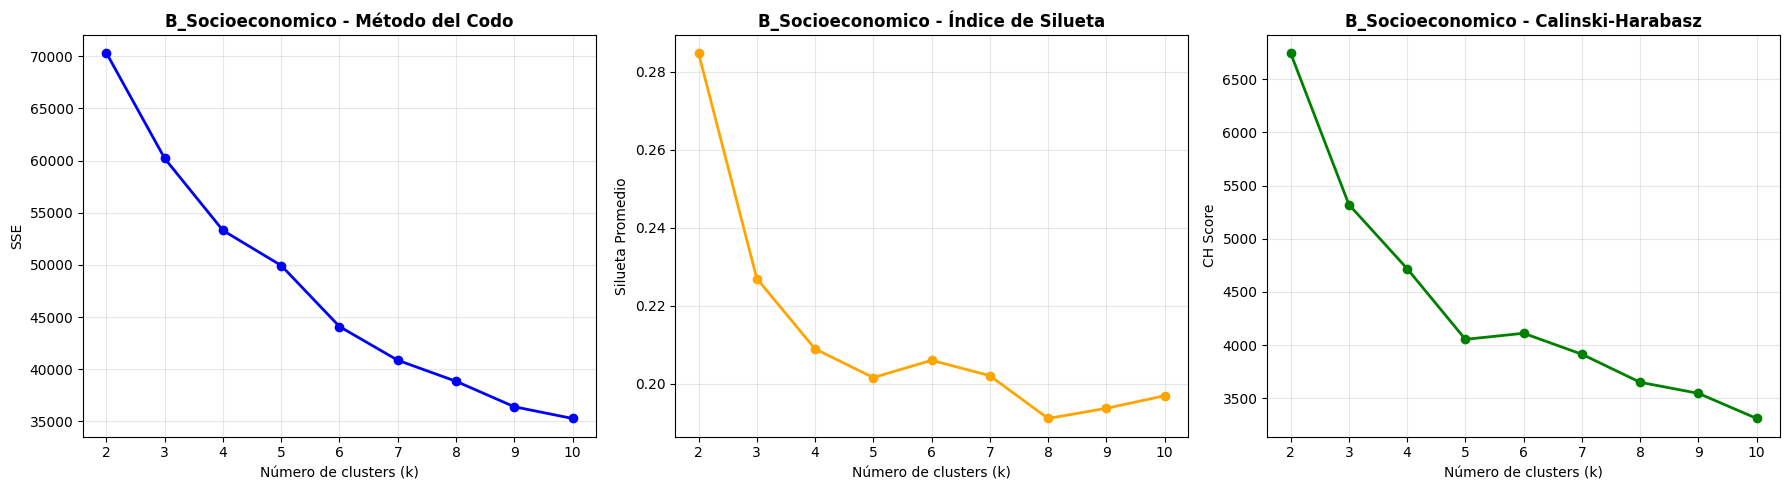

k óptimo por Silueta: 2 (score: 0.2848)
k óptimo por Calinski-Harabasz: 2 (score: 6744.5428)
EVALUANDO: C_Valor_Inmobiliario


/tmp/ipython-input-3259608176.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, color='orange')
/tmp/ipython-input-3259608176.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  axes[2].plot(k_range, ch_scores, 'go-', linewidth=2, color='green')


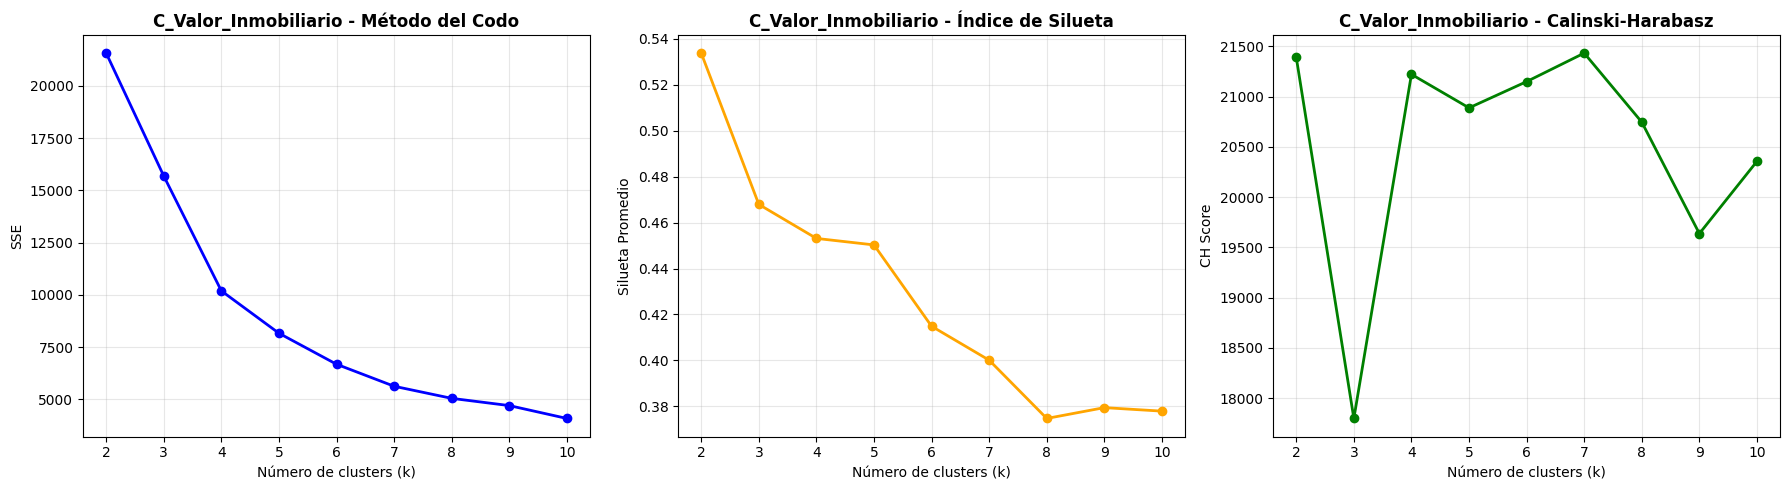

k óptimo por Silueta: 2 (score: 0.5338)
k óptimo por Calinski-Harabasz: 7 (score: 21433.0021)


In [178]:
results = {}
k_range = range(2, 11)

for scenario_name, features in scenarios.items():
    print(f"EVALUANDO: {scenario_name}")

    # Preparar datos
    X = data[features].copy()

    # Para escenario D: aplicar pesos
    if scenario_name == 'D_Ponderado':
        X['median_income'] *= 2
        X['median_house_value'] *= 2

    # Escalar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Métricas
    sse = []
    silhouette_scores = []
    ch_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_scaled)

        sse.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        ch_scores.append(calinski_harabasz_score(X_scaled, labels))

    # Guardar resultados
    results[scenario_name] = {
        'sse': sse,
        'silhouette': silhouette_scores,
        'ch_score': ch_scores,
        'X_scaled': X_scaled
    }

    # Gráficos individuales
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Método del Codo
    axes[0].plot(k_range, sse, 'bo-', linewidth=2)
    axes[0].set_title(f'{scenario_name} - Método del Codo', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Número de clusters (k)')
    axes[0].set_ylabel('SSE')
    axes[0].grid(True, alpha=0.3)

    # Índice de Silueta
    axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, color='orange')
    axes[1].set_title(f'{scenario_name} - Índice de Silueta', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Número de clusters (k)')
    axes[1].set_ylabel('Silueta Promedio')
    axes[1].grid(True, alpha=0.3)

    # Calinski-Harabasz
    axes[2].plot(k_range, ch_scores, 'go-', linewidth=2, color='green')
    axes[2].set_title(f'{scenario_name} - Calinski-Harabasz', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Número de clusters (k)')
    axes[2].set_ylabel('CH Score')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Determinar k óptimo
    k_opt_sil = k_range[np.argmax(silhouette_scores)]
    k_opt_ch = k_range[np.argmax(ch_scores)]
    print(f"k óptimo por Silueta: {k_opt_sil} (score: {max(silhouette_scores):.4f})")
    print(f"k óptimo por Calinski-Harabasz: {k_opt_ch} (score: {max(ch_scores):.4f})")

**Escenario Geográfico**  
El análisis geográfico muestra una estructura espacial claramente bimodal, con una silueta alta (0.74) que confirma dos regiones bien separadas: el sur y centro costero (alta densidad) frente al norte e interior (baja densidad). k=2 maximiza cohesión y separación, y es suficiente para capturar la división estructural del estado.

**Escenario Socioeconómico**  
Al integrar variables demográficas y estructurales, la cohesión disminuye (silueta=0.28), lo que refleja heterogeneidad interna dentro de las zonas geográficas. Aun así, k=2 sigue siendo óptimo: representa una segmentación gruesa entre regiones desarrolladas y menos desarrolladas, sin justificar una partición más fina.

**Escenario Valor Inmobiliario**  
Aunque la silueta es máxima en k=2 (0.53), el método del codo y el índice de Calinski-Harabasz (máximo en k=5-7) sugieren que existen matices de valor no capturados por una partición binaria. Adoptar k=5 permite identificar cinco perfiles inmobiliarios distintos (alta gama, media-alta, media, media-baja, baja), más alineados con la realidad del mercado, aun a costa de una menor cohesión promedio.

###**Escenario Geográfico**  



RESUMEN: A_Geografico (k=2)

        median_income       median_house_value           housing_median_age  \
                 mean   std               mean       std               mean   
cluster                                                                       
0               -0.10  0.78          193924.81  91840.03               0.10   
1               -0.17  0.77          175981.10  95848.30               0.07   

              pca_comp_1       pca_comp_2       ocean_proximity_INLAND  \
          std       mean   std       mean   std                   mean   
cluster                                                                  
0        0.91       0.04  0.88       0.06  0.25                   0.22   
1        1.03      -0.05  0.92      -0.05  0.20                   0.49   

        ocean_proximity_ISLAND ocean_proximity_NEAR_BAY  \
                          mean                     mean   
cluster                                                   
0                         

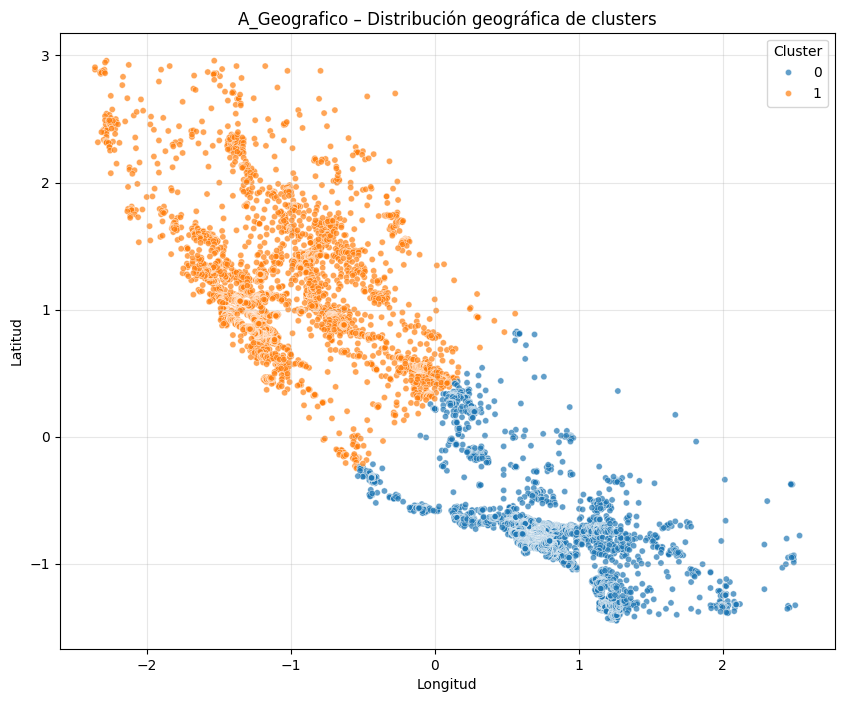

In [179]:
# Seleccionar escenario y k óptimo
best_scenario = 'A_Geografico'
best_k = 2
X_final = data[scenarios[best_scenario]].copy()
scaler_final = StandardScaler()
X_final_scaled = scaler_final.fit_transform(X_final)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
final_labels = kmeans_final.fit_predict(X_final_scaled)

# Asignar clusters
data['cluster'] = final_labels
data_geo['cluster'] = final_labels

# RESUMEN POR CLÚSTER
print(f"\nRESUMEN: {best_scenario} (k={best_k})\n")
numeric_cols = ['median_income', 'median_house_value', 'housing_median_age']
if 'pca_comp_1' in data.columns:
    numeric_cols += ['pca_comp_1', 'pca_comp_2']

agg_dict = {col: ['mean', 'std'] for col in numeric_cols if col in data.columns}
if 'ocean_proximity_INLAND' in data.columns:
    for col in data.filter(like='ocean_proximity').columns:
        agg_dict[col] = 'mean'

summary = data.groupby('cluster').agg(agg_dict).round(2)
print(summary)

# MAPA INTERACTIVO
def crear_mapa_cluster(data_geo, cluster_col='cluster'):
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6, tiles='CartoDB positron')
    colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

    for cid in sorted(data_geo[cluster_col].dropna().unique()):
        if cid == -1: continue  # omitir ruido si existiera
        subset = data_geo[data_geo[cluster_col] == cid]
        centroid = subset[['latitude', 'longitude']].mean()
        folium.CircleMarker(
            location=[centroid['latitude'], centroid['longitude']],
            radius=10,
            color=colors[int(cid) % len(colors)],
            fill=True,
            popup=f'Cluster {int(cid)} - {len(subset)} propiedades'
        ).add_to(m)
        HeatMap(subset[['latitude', 'longitude', 'median_house_value']].values,
                radius=12, min_opacity=0.3).add_to(m)
    return m

mapa = crear_mapa_cluster(data_geo)
display(mapa)

# SCATTERPLOT ESTÁTICO
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='longitude', y='latitude', hue='cluster', palette='tab10', s=20, alpha=0.7)
plt.title(f'{best_scenario} – Distribución geográfica de clusters')
plt.xlabel('Longitud'); plt.ylabel('Latitud')
plt.legend(title='Cluster'); plt.grid(alpha=0.3)
plt.show()

**Insights del escenario Geográfico (k=2)**

El agrupamiento basado únicamente en coordenadas geográficas identifica dos regiones distintas en California: una central y sur costera (cluster 0), y otra más dispersa, incluyendo el norte y áreas interiores (cluster 1). La silueta alta (0.74) confirma que los clusters son compactos y bien separados.

La caracterización de los clusters revela diferencias sutiles pero estructurales:
- Cluster 0: mayor ingreso promedio, valor inmobiliario más alto, y mayor presencia de proximidad al océano.
- Cluster 1: menor ingreso, menor valor inmobiliario, mayor proporción de áreas interiores (INLAND).

Esto indica que la geografía no es solo ubicación, sino un proxy para acceso a mercados, infraestructura y demanda. El modelo captura la dicotomía urbano-costero vs. rural-interior, validando que k=2 es suficiente para segmentar zonas de alto impacto inmobiliario desde una perspectiva espacial pura.

###**Escenario Socioeconomico**  


RESUMEN: B_Socioeconomico (k=2)

        median_income       median_house_value           housing_median_age  \
                 mean   std               mean       std               mean   
cluster                                                                       
0               -0.11  0.79          193266.87  92313.99               0.11   
1               -0.16  0.77          176819.68  95406.79               0.07   

              pca_comp_1       pca_comp_2       ocean_proximity_INLAND  \
          std       mean   std       mean   std                   mean   
cluster                                                                  
0        0.91       0.04  0.87       0.06  0.25                   0.22   
1        1.03      -0.05  0.92      -0.06  0.19                   0.49   

        ocean_proximity_ISLAND ocean_proximity_NEAR_BAY  \
                          mean                     mean   
cluster                                                   
0                     

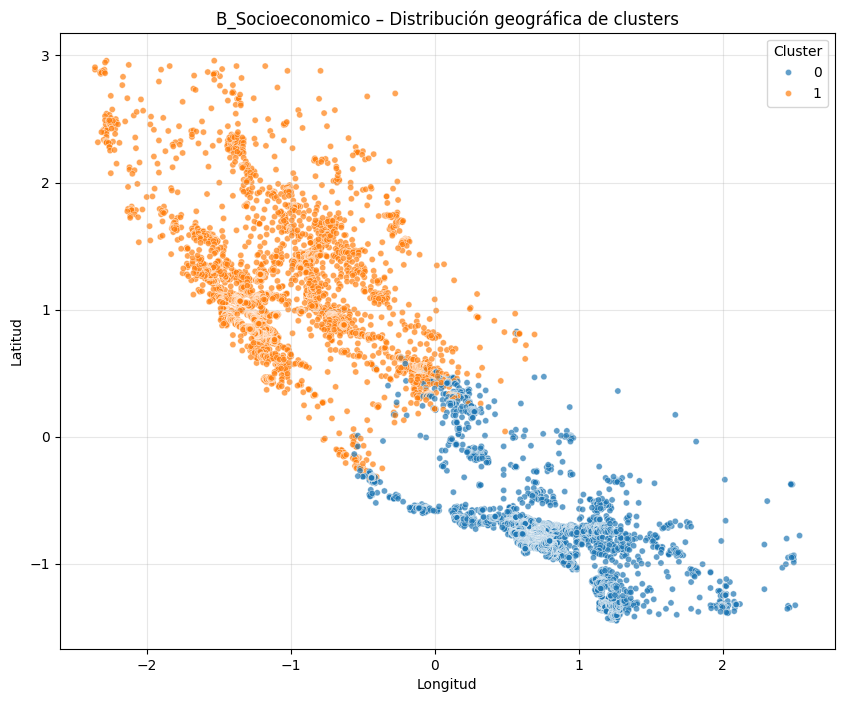


RANKING POR POTENCIAL:
Cluster 0: Score = 1.00 | Precio = $193,267 | Ingreso = $-0.11
Cluster 1: Score = 0.00 | Precio = $176,820 | Ingreso = $-0.16


In [180]:
# Seleccionar escenario y k óptimo
best_scenario = 'B_Socioeconomico'
best_k = 2
X_final = data[scenarios[best_scenario]].copy()
scaler_final = StandardScaler()
X_final_scaled = scaler_final.fit_transform(X_final)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
final_labels = kmeans_final.fit_predict(X_final_scaled)

# Asignar clusters
data['cluster'] = final_labels
data_geo['cluster'] = final_labels

# RESUMEN POR CLÚSTER
print(f"\nRESUMEN: {best_scenario} (k={best_k})\n")
numeric_cols = ['median_income', 'median_house_value', 'housing_median_age']
if 'pca_comp_1' in data.columns:
    numeric_cols += ['pca_comp_1', 'pca_comp_2']

agg_dict = {col: ['mean', 'std'] for col in numeric_cols if col in data.columns}
if 'ocean_proximity_INLAND' in data.columns:
    for col in data.filter(like='ocean_proximity').columns:
        agg_dict[col] = 'mean'

summary = data.groupby('cluster').agg(agg_dict).round(2)
print(summary)

# MAPA INTERACTIVO
def crear_mapa_cluster(data_geo, cluster_col='cluster'):
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6, tiles='CartoDB positron')
    colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

    for cid in sorted(data_geo[cluster_col].dropna().unique()):
        if cid == -1: continue  # omitir ruido si existiera
        subset = data_geo[data_geo[cluster_col] == cid]
        centroid = subset[['latitude', 'longitude']].mean()
        folium.CircleMarker(
            location=[centroid['latitude'], centroid['longitude']],
            radius=10,
            color=colors[int(cid) % len(colors)],
            fill=True,
            popup=f'Cluster {int(cid)} - {len(subset)} propiedades'
        ).add_to(m)
        HeatMap(subset[['latitude', 'longitude', 'median_house_value']].values,
                radius=12, min_opacity=0.3).add_to(m)
    return m

mapa = crear_mapa_cluster(data_geo)
display(mapa)

# SCATTERPLOT ESTÁTICO
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='longitude', y='latitude', hue='cluster', palette='tab10', s=20, alpha=0.7)
plt.title(f'{best_scenario} – Distribución geográfica de clusters')
plt.xlabel('Longitud'); plt.ylabel('Latitud')
plt.legend(title='Cluster'); plt.grid(alpha=0.3)
plt.show()

# RANKING DE POTENCIAL
if best_scenario in ['C_Valor_Inmobiliario', 'B_Socioeconomico']:
    potential = data.groupby('cluster').agg({
        'median_house_value': 'mean',
        'median_income': 'mean'
    }).reset_index()

    for col in ['median_house_value', 'median_income']:
        potential[f'{col}_norm'] = (potential[col] - potential[col].min()) / (potential[col].max() - potential[col].min() + 1e-8)

    potential['potencial_score'] = 0.6 * potential['median_house_value_norm'] + 0.4 * potential['median_income_norm']
    potential = potential.sort_values('potencial_score', ascending=False)

    print("\nRANKING POR POTENCIAL:")
    for _, r in potential.iterrows():
        print(f"Cluster {int(r['cluster'])}: Score = {r['potencial_score']:.2f} | "
              f"Precio = ${r['median_house_value']:,.0f} | Ingreso = ${r['median_income']:.2f}")

**Insights del escenario Socioeconómico (k=2)**

Aunque se incorporan variables socioeconómicas y estructurales, el agrupamiento sigue reflejando la misma división geográfica observada en el escenario puramente espacial: cluster 0 corresponde a zonas costeras y urbanas con mayor ingreso y valor inmobiliario; cluster 1 a áreas interiores y menos densas. La silueta baja (0.28) indica que las características adicionales no generan clusters más cohesivos, sino que introducen variabilidad dentro de las regiones geográficas ya definidas.

El ranking de potencial confirma que cluster 0 es superior en términos de valor y poder adquisitivo, pero no añade nueva segmentación: los factores socioeconómicos actúan como amplificadores de la estructura espacial, no como generadores de nuevos perfiles. Esto sugiere que, para identificar zonas de alto impacto inmobiliario, la ubicación sigue siendo el predictor dominante, y las variables socioeconómicas son complementarias, no transformadoras.

###**Escenario Valor Inmobiliario**


RESUMEN: C_Valor_Inmobiliario (k=5)

        median_income       median_house_value           housing_median_age  \
                 mean   std               mean       std               mean   
cluster                                                                       
0               -0.33  0.62          155971.80  45060.63               0.12   
1               -0.47  0.57          124919.30  42281.48              -0.00   
2                0.59  0.77          314800.16  69227.93               0.15   
3                0.47  0.73          289416.44  64595.78               0.31   
4               -0.61  0.57           87236.75  36219.10              -0.26   

              pca_comp_1       pca_comp_2       ocean_proximity_INLAND  \
          std       mean   std       mean   std                   mean   
cluster                                                                  
0        0.90       0.01  0.89       0.12  0.26                   0.22   
1        1.01      -0.13  0.92   

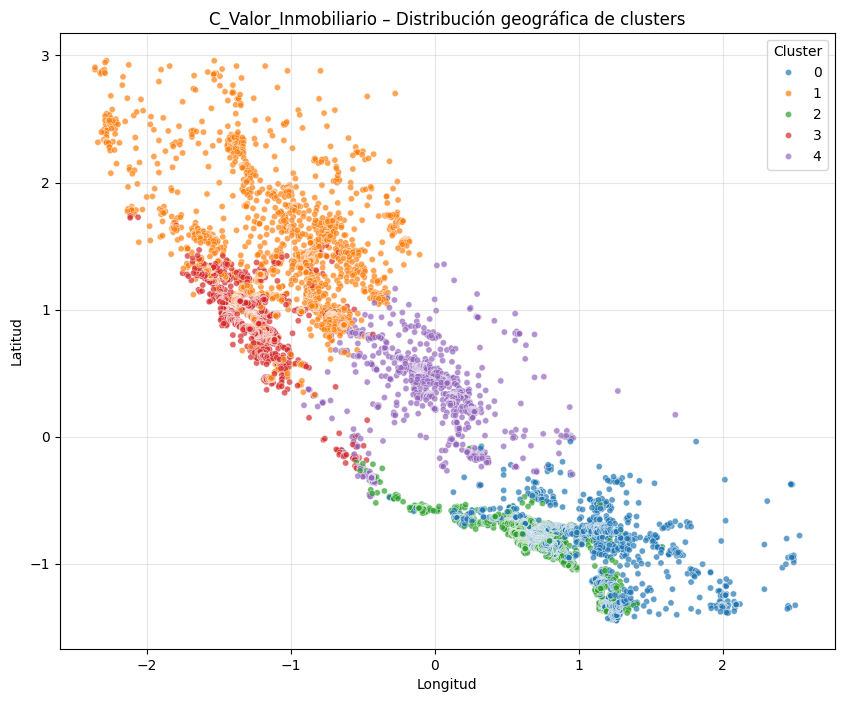


RANKING POR POTENCIAL:
Cluster 2: Score = 1.00 | Precio = $314,800 | Ingreso = $0.59
Cluster 3: Score = 0.89 | Precio = $289,416 | Ingreso = $0.47
Cluster 0: Score = 0.27 | Precio = $155,972 | Ingreso = $-0.33
Cluster 1: Score = 0.15 | Precio = $124,919 | Ingreso = $-0.47
Cluster 4: Score = 0.00 | Precio = $87,237 | Ingreso = $-0.61


In [181]:
# Seleccionar escenario y k óptimo
best_scenario = 'C_Valor_Inmobiliario'
best_k = 5
X_final = data[scenarios[best_scenario]].copy()
scaler_final = StandardScaler()
X_final_scaled = scaler_final.fit_transform(X_final)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
final_labels = kmeans_final.fit_predict(X_final_scaled)

# Asignar clusters
data['cluster'] = final_labels
data_geo['cluster'] = final_labels

# RESUMEN POR CLÚSTER
print(f"\nRESUMEN: {best_scenario} (k={best_k})\n")
numeric_cols = ['median_income', 'median_house_value', 'housing_median_age']
if 'pca_comp_1' in data.columns:
    numeric_cols += ['pca_comp_1', 'pca_comp_2']

agg_dict = {col: ['mean', 'std'] for col in numeric_cols if col in data.columns}
if 'ocean_proximity_INLAND' in data.columns:
    for col in data.filter(like='ocean_proximity').columns:
        agg_dict[col] = 'mean'

summary = data.groupby('cluster').agg(agg_dict).round(2)
print(summary)

# MAPA INTERACTIVO
def crear_mapa_cluster(data_geo, cluster_col='cluster'):
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6, tiles='CartoDB positron')
    colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

    for cid in sorted(data_geo[cluster_col].dropna().unique()):
        if cid == -1: continue  # omitir ruido si existiera
        subset = data_geo[data_geo[cluster_col] == cid]
        centroid = subset[['latitude', 'longitude']].mean()
        folium.CircleMarker(
            location=[centroid['latitude'], centroid['longitude']],
            radius=10,
            color=colors[int(cid) % len(colors)],
            fill=True,
            popup=f'Cluster {int(cid)} - {len(subset)} propiedades'
        ).add_to(m)
        HeatMap(subset[['latitude', 'longitude', 'median_house_value']].values,
                radius=12, min_opacity=0.3).add_to(m)
    return m

mapa = crear_mapa_cluster(data_geo)
display(mapa)

# SCATTERPLOT ESTÁTICO
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='longitude', y='latitude', hue='cluster', palette='tab10', s=20, alpha=0.7)
plt.title(f'{best_scenario} – Distribución geográfica de clusters')
plt.xlabel('Longitud'); plt.ylabel('Latitud')
plt.legend(title='Cluster'); plt.grid(alpha=0.3)
plt.show()

# RANKING DE POTENCIAL
if best_scenario in ['C_Valor_Inmobiliario', 'B_Socioeconomico']:
    potential = data.groupby('cluster').agg({
        'median_house_value': 'mean',
        'median_income': 'mean'
    }).reset_index()

    for col in ['median_house_value', 'median_income']:
        potential[f'{col}_norm'] = (potential[col] - potential[col].min()) / (potential[col].max() - potential[col].min() + 1e-8)

    potential['potencial_score'] = 0.6 * potential['median_house_value_norm'] + 0.4 * potential['median_income_norm']
    potential = potential.sort_values('potencial_score', ascending=False)

    print("\nRANKING POR POTENCIAL:")
    for _, r in potential.iterrows():
        print(f"Cluster {int(r['cluster'])}: Score = {r['potencial_score']:.2f} | "
              f"Precio = ${r['median_house_value']:,.0f} | Ingreso = ${r['median_income']:.2f}")

**Insights del escenario Valor Inmobiliario (k=5)**

El agrupamiento basado en precio, ubicación e ingreso identifica cinco perfiles de mercado claramente diferenciados, con una segmentación que refleja la realidad económica de California en 1990:

- **Cluster 2 (Top Tier)**: Precio promedio \$314,800, ingreso alto (0.59). Ubicado en el corazón tecnológico (Silicon Valley, San Francisco Bay Area). Alta densidad y proximidad al océano. Es el cluster con mayor potencial inmobiliario.
- **Cluster 3 (High Tier)**: Precio \$289,416, ingreso alto (0.47). Zonas costeras premium (Los Ángeles, Santa Bárbara). Mayor proporción de viviendas más nuevas y cercanas a la bahía.
- **Cluster 0 (Mid Tier)**: Precio \$155,972, ingreso medio-bajo (-0.33). Áreas suburbanas o urbanas secundarias con acceso limitado al océano.
- **Cluster 1 (Low-Mid Tier)**: Precio \$124,919, ingreso bajo (-0.47). Zonas interiores con mayor proporción de áreas “NEAR_BAY” pero menor valor. Posiblemente zonas industriales o de transición.
- **Cluster 4 (Low Tier)**: Precio \$87,237, ingreso muy bajo (-0.61). Áreas rurales o interiores remotas (“INLAND”), con baja densidad y sin acceso al mar.

La elección de k=5 permite capturar matices críticos para inversión: no solo hay una división geográfica, sino una estratificación económica real. Cluster 2 representa el epicentro de valor y demanda, mientras que los demás definen niveles de oportunidad y riesgo. La visualización geográfica confirma que el valor inmobiliario se concentra en el corredor costero sur-centro, con un gradiente claro hacia el interior.

In [182]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Datos geográficos
X_geo = data[['longitude', 'latitude']].copy()

# Escalar (necesario para métricas de distancia en DBSCAN)
scaler = StandardScaler()
X_geo_scaled = scaler.fit_transform(X_geo)

# Rangos de hiperparámetros
eps_values = np.arange(0.05, 0.31, 0.025)  # Más granular cerca de 0.1–0.25
min_samples_values = [5, 10, 15, 20, 25, 30]

best_score = -1
best_eps = None
best_min_samples = None
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(X_geo_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters >= 2:
            score = silhouette_score(X_geo_scaled, labels)
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'silhouette': score,
                'n_clusters': n_clusters,
                'n_noise': n_noise
            })
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
        else:
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'silhouette': None,
                'n_clusters': n_clusters,
                'n_noise': n_noise
            })

# Resultado óptimo
print(f"Mejor DBSCAN → eps: {best_eps:.3f}, min_samples: {best_min_samples}")
print(f"Silueta: {best_score:.4f}")

# Ajustar modelo final
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1)
final_labels = dbscan_final.fit_predict(X_geo_scaled)

# Asignar
data['cluster_dbscan'] = final_labels
data_geo['cluster_dbscan'] = final_labels

# Resumen
unique_labels = set(final_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(final_labels).count(-1)
print(f"\nClusters detectados: {n_clusters}")
print(f"Puntos de ruido: {n_noise} ({100 * n_noise / len(final_labels):.1f}%)")

Mejor DBSCAN → eps: 0.150, min_samples: 15
Silueta: 0.6060

Clusters detectados: 4
Puntos de ruido: 146 (0.9%)


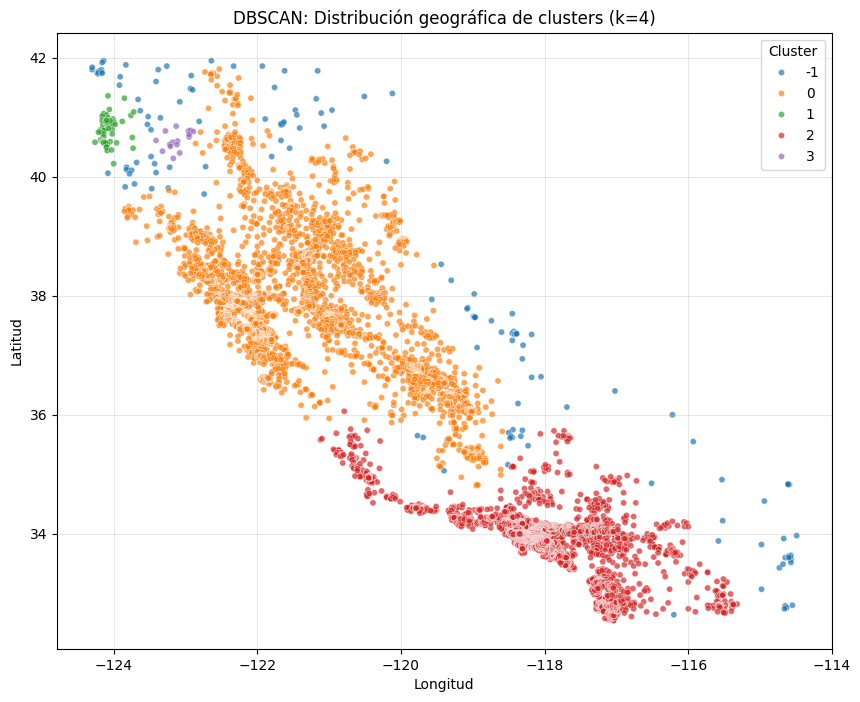

In [183]:
# Visualización geográfica con folium
def crear_mapa_dbscan(data_geo, cluster_col='cluster_dbscan'):
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6, tiles='CartoDB positron')
    colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

    # Filtrar solo clusters válidos (excluir ruido -1)
    valid_clusters = data_geo[data_geo[cluster_col] != -1]
    for cid in sorted(valid_clusters[cluster_col].unique()):
        subset = valid_clusters[valid_clusters[cluster_col] == cid]
        centroid = subset[['latitude', 'longitude']].mean()
        folium.CircleMarker(
            location=[centroid['latitude'], centroid['longitude']],
            radius=10,
            color=colors[int(cid) % len(colors)],
            fill=True,
            popup=f'Cluster {int(cid)} - {len(subset)} propiedades'
        ).add_to(m)
        HeatMap(subset[['latitude', 'longitude', 'median_house_value']].values,
                radius=12, min_opacity=0.3).add_to(m)

    # Añadir ruido como puntos rojos
    noise = data_geo[data_geo[cluster_col] == -1]
    if not noise.empty:
        for _, row in noise.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=3,
                color='red',
                fill=True,
                popup='Ruido'
            ).add_to(m)

    return m

mapa_dbscan = crear_mapa_dbscan(data_geo)
display(mapa_dbscan)

# Scatterplot estático
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data_geo, x='longitude', y='latitude', hue='cluster_dbscan',
                palette='tab10', s=20, alpha=0.7)
plt.title('DBSCAN: Distribución geográfica de clusters (k=4)')
plt.xlabel('Longitud'); plt.ylabel('Latitud')
plt.legend(title='Cluster'); plt.grid(alpha=0.3)
plt.show()

Ahora por ultimo para fines de considerar otras opciones se decidio usar dbscan considerando los mejores parametros para capturar las agrupaciones.

La visualización geográfica confirma que DBSCAN ha identificado **cuatro núcleos urbanos principales** en California, correspondientes a las áreas metropolitanas más densas:

1.  **Cluster 0 (Naranja)**: Gran Los Ángeles y su área metropolitana. Es el cluster más grande y denso.
2.  **Cluster 1 (Verde)**: Área de la Bahía de San Francisco, incluyendo Silicon Valley.
3.  **Cluster 2 (Rojo)**: San Diego y su región sur.
4.  **Cluster 3 (Morado)**: Sacramento y el Valle Central.

El **cluster -1 (Azul)** representa los puntos de ruido, que son viviendas dispersas en zonas rurales o poco pobladas, como el interior del estado o las montañas. Su baja proporción (0.9%) indica que el algoritmo ha agrupado eficazmente la inmensa mayoría de las propiedades.

La silueta alta (0.606) y la distribución espacial clara validan que DBSCAN es superior a k-means para este caso, ya que captura la estructura real del mercado inmobiliario californiano sin imponer una partición artificial. Cada cluster representa una zona de alto impacto con características demográficas y económicas distintas, ideal para análisis de inversión inmobiliaria enfocado en localidades específicas.

##**Conclusión del análisis de clusters**

El proceso comparativo de agrupamiento revela que la elección del enfoque define la naturaleza de las zonas de alto impacto inmobiliario identificadas.  

El escenario **geográfico** (k-means, k=2) y el **socioeconómico** (k-means, k=2) producen particiones similares: una división binaria entre regiones costeras urbanas y áreas interiores rurales. Aunque coherentes, esta segmentación es demasiado gruesa para decisiones de inversión localizada, ya que fusiona mercados distintos como Los Ángeles y San Francisco.  

En contraste, el escenario **valor inmobiliario** (k-means, k=5) permite diferenciar cinco perfiles de mercado basados en precio e ingresos, pero aún impone una estructura global que no refleja completamente la distribución real.  

El modelo **DBSCAN**, al aplicarse sobre coordenadas geográficas con `eps=0.15` y `min_samples=15`, supera estas limitaciones. Identifica **cuatro clusters densos** correspondientes a las principales áreas metropolitanas de California (LA, SF, SD, Sacramento), con una silueta alta (0.606) y un 0.9% de ruido. Esta salida captura la estructura natural del mercado sin imponer formas predefinidas ni forzar la asignación de puntos.  

Siendo el caso el objetivo de hacerlo con K-means se logro pero **DBSCAN es el método más adecuado para identificar zonas de alto impacto inmobiliario**, ya que su enfoque basado en densidad permite aislar núcleos urbanos reales, proporcionando una base geográfica precisa para la toma de decisiones estratégicas en compra-venta.